In [1]:
import os
import argparse
import numpy as np
import pandas as pd
from scipy.stats import mode
from sklearn.decomposition import PCA
import torch
import torch.nn.functional as F
import seaborn as sns
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib widget
from pprint import pprint

from config import EMBEDDINGS_DIR

In [2]:
wtc_df = pd.read_csv('/cronus_data/rrao/wtc_clinic/seg_persona.csv').drop(columns=['filename', 'message'])
hitop_df = pd.read_csv('/cronus_data/rrao/hitop/seg_persona.csv').drop(columns=['filename', 'message'])

In [3]:
wtc_embs = pd.read_csv('/cronus_data/rrao/WhiSBERT/embeddings/all-MiniLM-L12-v2/wtc_embeddings.csv').dropna().rename(columns={'segment_id': 'message_id'})
hitop_embs = pd.read_csv('/cronus_data/rrao/WhiSBERT/embeddings/all-MiniLM-L12-v2/hitop_embeddings.csv').dropna().rename(columns={'segment_id': 'message_id'})

In [4]:
outcomes = pd.concat([wtc_df, hitop_df], axis=0, ignore_index=True)
embs = pd.concat([wtc_embs, hitop_embs], axis=0, ignore_index=True)

In [6]:
# agg_df = pd.merge(hitop_df, emb_df, how='right', on='message_id').drop(columns='message_id')
# agg_df = agg_df.groupby('user_id', as_index=False).mean().drop(columns='user_id')
agg_df = pd.merge(outcomes, embs, how='right', on='message_id').drop(columns=['user_id', 'message_id']).dropna()
agg_df

,valence,arousal,ope,agr,ext,con,neu,ang_norm,anx_norm,dep_norm,...,f374,f375,f376,f377,f378,f379,f380,f381,f382,f383
0,5.492248,2.434264,1.078491,3.538978,2.419177,-1.841604,-0.317128,1.816210,2.843166,1.998169,...,0.031678,-0.036200,0.033863,0.004600,0.063568,0.063140,0.052456,0.024611,0.053543,0.059069
1,5.345472,2.215654,5.080293,0.166491,-2.165736,-2.827166,1.538005,2.878643,3.546717,3.676692,...,0.000716,0.005423,0.080140,0.005369,0.030937,0.011622,0.058191,0.037399,0.026069,0.044603
2,5.345472,2.215654,5.080293,0.166491,-2.165736,-2.827166,1.538005,2.878643,3.546717,3.676692,...,-0.019591,-0.001969,0.043371,0.010914,0.013996,0.022936,0.057911,0.041148,0.008372,0.041009
3,5.862403,2.205863,1.145501,6.618364,4.583606,-1.471796,-0.623336,1.108454,2.612091,2.128935,...,0.045717,-0.090909,0.034390,0.020780,0.058275,0.102914,0.070823,0.082695,-0.009661,0.046030
4,4.469452,1.632236,2.591754,1.388986,-0.087364,-7.546930,5.881711,3.587798,3.400176,-2.344270,...,-0.080296,-0.086024,0.017136,0.019137,0.040391,-0.072536,0.018324,0.019036,0.066409,-0.091498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726017,4.868516,2.168575,-2.111855,-3.774477,4.893564,4.617974,-0.347223,6.851456,2.012588,-0.135535,...,0.020146,-0.019341,-0.013689,-0.006044,-0.068279,-0.029366,-0.053802,-0.009434,-0.021545,0.079775
726019,5.143191,2.198984,9.212935,2.315006,-7.801025,-7.491872,3.579342,-2.776020,0.317252,3.993117,...,0.046992,-0.001953,-0.058689,-0.005668,0.034324,0.031395,-0.075359,0.046120,-0.029264,0.046044
726020,5.014759,2.366074,11.030973,1.020247,-1.806953,-4.181623,-5.101836,-1.467750,-0.131700,1.204343,...,-0.127967,-0.000660,-0.006330,-0.017517,0.008965,-0.011897,0.035845,0.022179,-0.117585,0.055960
726021,5.862231,2.522707,-0.677049,-2.860874,1.331570,1.301145,0.250222,4.560347,4.227186,4.138852,...,-0.000537,0.016490,-0.003721,-0.015859,-0.056227,0.027022,0.054575,-0.036430,-0.086609,-0.061887


In [ ]:
data = agg_df.to_numpy()
predictions = data[:, :10]
embeddings = data[:, 10:]

# Correlation matrix to store correlations of each feature with each outcome
correlation_matrix = np.zeros((10, embeddings.shape[1]))

# Compute correlations for each prediction outcome
for i in range(predictions.shape[1]):  # For each prediction outcome
    pred = predictions[:, i]  # Select the ith prediction outcome
    
    for j in range(embeddings.shape[1]):  # For each feature
        correlation_matrix[i, j] = np.corrcoef(pred, embeddings[:, j])[0, 1]

# Replace NaN correlations (e.g., due to constant columns) with 0
correlation_matrix = np.nan_to_num(correlation_matrix)

# Compute the mean absolute correlation for each feature across all outcomes
mean_correlations = np.mean(np.abs(correlation_matrix), axis=0)

# Get the indices of the 10 least correlated features
least_correlated_indices = np.argsort(mean_correlations)[:10]

print("Indices of the 10 least correlated features:", least_correlated_indices)

Indices of the 10 least correlated features: [319   0 233 351 185 324 145 359 246  60]


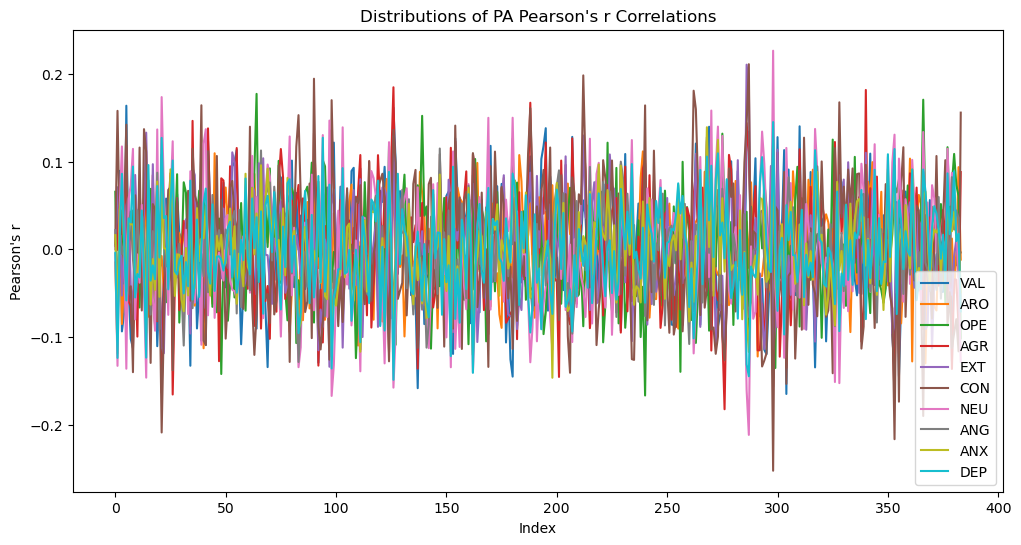

In [11]:
# Distribution labels
distribution_labels = [
    "VAL", "ARO", "OPE", "AGR", "EXT",
    "CON", "NEU", "ANG", "ANX", "DEP"
]

# Plotting the distributions
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

# Plot each distribution
for i in range(correlation_matrix.shape[0]):
    plt.plot(correlation_matrix[i], label=distribution_labels[i])

# Adding labels and title
plt.xlabel("Index")
plt.ylabel("Pearson's r")
plt.title("Distributions of PA Pearson's r Correlations")
plt.legend()

# Show the plot
plt.show()  

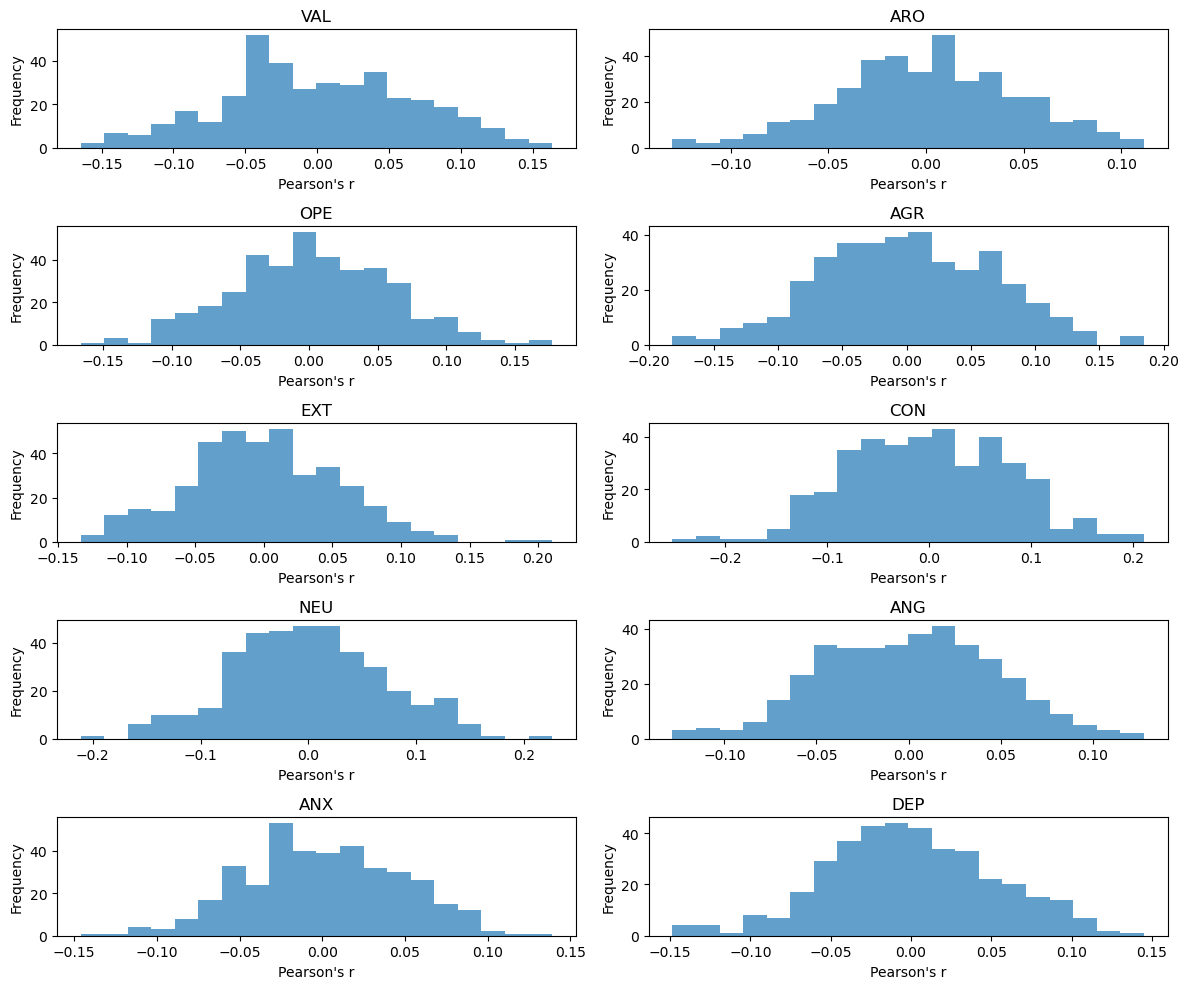

In [13]:
# Plotting the histograms
plt.figure(figsize=(12, 10))  # Adjust the figure size

# Plot each histogram
for i in range(correlation_matrix.shape[0]):
    plt.subplot(5, 2, i + 1)  # Create a 5x2 grid of subplots
    plt.hist(correlation_matrix[i], bins=20, alpha=0.7)  # 20 bins for each histogram
    plt.title(distribution_labels[i])  # Set the title to the label for each distribution
    plt.xlabel('Pearson\'s r')
    plt.ylabel('Frequency')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

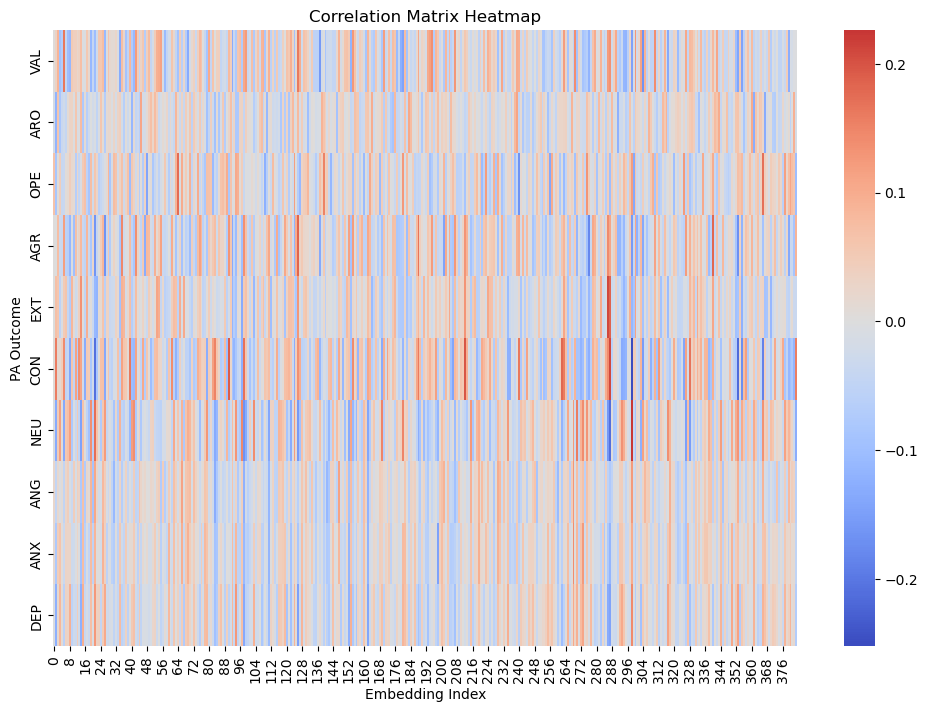

In [9]:
# Names for the 10 PA outcomes
pa_outcome_labels = [
    "VAL", "ARO", "OPE", "AGR", "EXT",
    "CON", "NEU", "ANG", "ANX", "DEP"
]

# Plotting the heatmap
plt.figure(figsize=(12, 8))  # Adjust the size as needed
sns.heatmap(
    correlation_matrix,
    cmap="coolwarm",
    center=0,
    annot=False,
    cbar=True,
    yticklabels=pa_outcome_labels,
)

# Add labels and title
plt.xlabel("Embedding Index")
plt.ylabel("PA Outcome")
plt.title("Correlation Matrix Heatmap")

# Show the heatmap
plt.show()

In [3]:
dataset_name = 'wtc'

In [ ]:
seg_path = f'/cronus_data/rrao/{dataset_name if dataset_name == "hitop" else "wtc_clinic"}/seg_persona.csv'
seg_df = pd.read_csv(seg_path).drop(columns=['filename'])
seg_df

In [5]:
pca = PCA(n_components=3)
gt_emb_df = pd.read_csv(os.path.join(EMBEDDINGS_DIR, 'all-MiniLM-L12-v2', f'{dataset_name}_embeddings.csv'))
gt_embs_pca = pca.fit_transform(gt_emb_df[gt_emb_df.columns[1:]].values)
emb_df = pd.read_csv(os.path.join(EMBEDDINGS_DIR, 'whisper-384', f'{dataset_name}_embeddings.csv'))
embs_pca = pca.fit_transform(emb_df[emb_df.columns[1:]].values)
aligned_emb_df = pd.read_csv(os.path.join(EMBEDDINGS_DIR, 'whisper-384_mean_cos-sim_50_512_1e-5_1e-2', f'{dataset_name}_embeddings.csv'))
aligned_emb_pca = pca.fit_transform(aligned_emb_df[aligned_emb_df.columns[1:]].values)

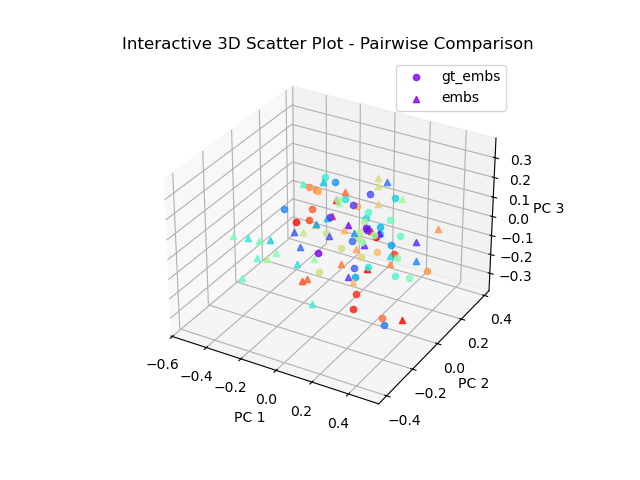

In [6]:
num_points = 50
# colors = plt.cm.viridis(np.linspace(0, 1, num_points))
colors = plt.cm.rainbow(np.linspace(0, 1, num_points))
# colors = plt.cm.jet(np.linspace(0, 1, num_points))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Step 3: Plot points from gt_embs_pca and embs_pca, using the same color for each pair
for i in range(num_points):
    # Plot a single point from gt_embs_pca
    ax.scatter(
        gt_embs_pca[i, 0],
        gt_embs_pca[i, 1],
        gt_embs_pca[i, 2],
        color=colors[i],
        label='gt_embs' if i == 0 else "",  # Label only the first instance for the legend
        alpha=0.8
    )
    
    # Plot the corresponding point from embs_pca
    ax.scatter(
        embs_pca[i, 0],
        embs_pca[i, 1],
        embs_pca[i, 2],
        color=colors[i],
        label='embs' if i == 0 else "",  # Label only the first instance for the legend
        marker='^',  # Different marker for differentiation
        alpha=0.8
    )

# Step 4: Set labels, legend, and title
ax.set_title('Interactive 3D Scatter Plot - Pairwise Comparison')
ax.legend()
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

# Display the plot
plt.show()

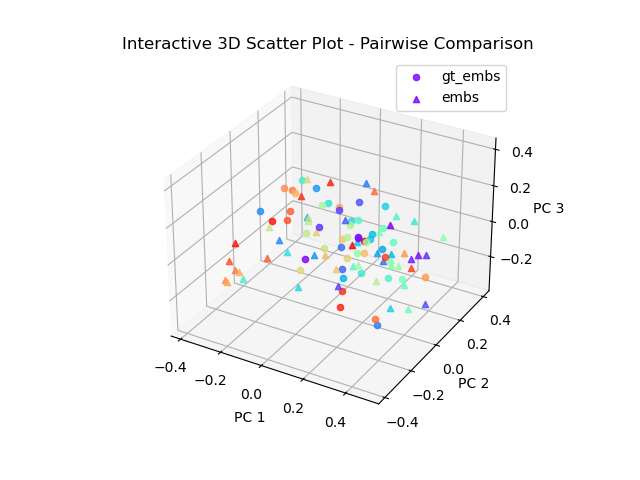

In [7]:
num_points = 50
# colors = plt.cm.viridis(np.linspace(0, 1, num_points))
colors = plt.cm.rainbow(np.linspace(0, 1, num_points))
# colors = plt.cm.jet(np.linspace(0, 1, num_points))

# Step 2: Set up the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Step 3: Plot points from gt_embs_pca and embs_pca, using the same color for each pair
for i in range(num_points):
    ax.scatter(
        gt_embs_pca[i, 0],
        gt_embs_pca[i, 1],
        gt_embs_pca[i, 2],
        color=colors[i],
        label='gt_embs' if i == 0 else "",  # Label only the first instance for the legend
        alpha=0.8
    )
    
    ax.scatter(
        aligned_emb_pca[i, 0],
        aligned_emb_pca[i, 1],
        aligned_emb_pca[i, 2],
        color=colors[i],
        label='embs' if i == 0 else "",  # Label only the first instance for the legend
        marker='^',  # Different marker for differentiation
        alpha=0.8
    )

# Step 4: Set labels, legend, and title
ax.set_title('Interactive 3D Scatter Plot - Pairwise Comparison')
ax.legend()
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

# Display the plot
plt.show()

### Residual Correlation Plot for Result Visualization

In [15]:
data = """
0.618
0.707
0.684
0.642
0.659
0.689
0.513
0.786
0.819
0.586
0.84
0.74
0.631
0.715
0.69
0.75
0.732
0.679
0.698
0.731
0.625
0.798
0.837
0.638
0.84
0.818
0.736
0.76
0.72
0.808
0.755
0.724
0.765
0.74
0.651
0.804
0.855
0.657
0.841
0.848
0.747
0.79
"""
data = data.strip().split('\n')
values = []
for i in range(0, len(data), 7):
    dataset = 'iHiTOP' if i % 14 else 'WTC'
    values.append({dataset: [float(v) for v in data[i:i+7]]})

import numpy as np
from pprint import pprint
averaged_arrays = []
for i in range(0, len(values), 2):
    wtc = np.array(values[i].get('WTC'))
    ihitop = np.array(values[i + 1].get('iHiTOP'))
    avg = (wtc + ihitop) / 2
    averaged_arrays.append(avg)
pprint(averaged_arrays)

[array([0.702 , 0.763 , 0.635 , 0.741 , 0.6995, 0.66  , 0.614 ]),
 array([0.744 , 0.7935, 0.685 , 0.7595, 0.758 , 0.7335, 0.6925]),
 array([0.762 , 0.8315, 0.706 , 0.7825, 0.8065, 0.7435, 0.7205])]


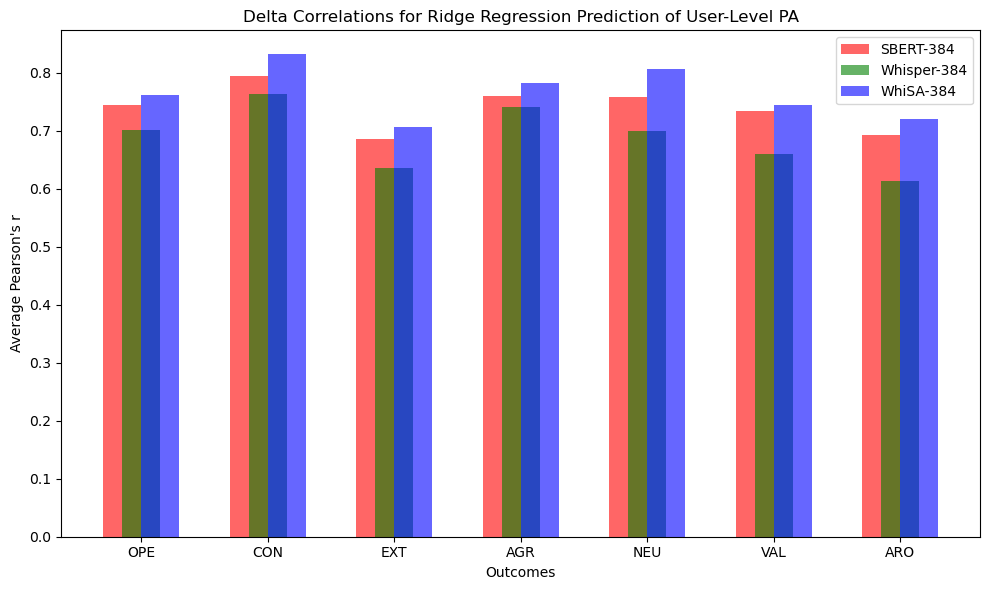

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
outcomes = ['OPE', 'CON', 'EXT', 'AGR', 'NEU', 'VAL', 'ARO', 'ANG', 'ANX', 'DEP']
whisper_values = [0.48, 0.69, 0.56, 0.68, 0.61, 0.58, 0.61, 0.22]
sbert_values = [0.63, 0.73, 0.69, 0.75, 0.73, 0.68, 0.70, 0.35]
better_values = [0.65, 0.75, 0.74, 0.81, 0.78, 0.73, 0.77, 0.34]

# Set up the x positions and width of each group of bars
x = np.arange(len(outcomes))
bar_width = 0.2  # Width of each individual bar (smaller to fit 4 bars)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each set of bars, slightly offset to overlap
ax.bar(x - 1.5 * bar_width, averaged_arrays[0], width=bar_width, color='yellow', alpha=0.6, label='Whisper-384')
ax.bar(x - 0.5 * bar_width, averaged_arrays[1], width=bar_width, color='red', alpha=0.6, label='SBERT-384')
ax.bar(x + 0.5 * bar_width, averaged_arrays[2], width=bar_width, color='blue', alpha=0.6, label='WhiSA-384')
ax.bar(x + 1.5 * bar_width, averaged_arrays[3], width=bar_width, color='green', alpha=0.6, label='WhiSPA-384')

# Add labels and title
ax.set_xlabel('Outcomes')
ax.set_ylabel('Average Pearson\'s r')
ax.set_title('Delta Correlations for Ridge Regression Prediction of User-Level PA')
ax.set_xticks(x)
ax.set_xticklabels(outcomes)
ax.legend()

# Show plot
plt.tight_layout()
plt.show()